In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bag of words

## Get Data

In [ ]:
import pandas as pd
import nltk

file_path = '/content/drive/MyDrive/data/train.csv'

# Load and preprocess the dataset
dataset = pd.read_csv(file_path)

# find the amount of 0 and 1 in label in position 2
max_dataset_length = 100000
not_toxic_count= dataset.iloc[:, 2].value_counts()[0]
toxic_count= dataset.iloc[:, 2].value_counts()[1]
min_count = min(not_toxic_count, toxic_count, int(max_dataset_length / 2))

# get first min count of not toxic and toxic
currect_df = dataset[dataset['toxic'] == 0].head(min_count)
toxic_df = dataset[dataset['toxic'] == 1].head(min_count)

# concat the dataframes
dataset = pd.concat([currect_df, toxic_df])
dataset_length= len(dataset)
print("database_lenght is",dataset_length)

# reset dataset index
dataset = dataset.reset_index(drop=True)

# initialize important variables
nltk.download('stopwords')
all_stopwords = nltk.corpus.stopwords.words('english')
all_stopwords.remove('not')

database_lenght is 30588


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Cleaning the texts

example


In [ ]:
from nltk.stem.porter import PorterStemmer
import re

ps = PorterStemmer()
for i in range(0, 1):
    comment = "Why are the edits made under my username 'Hardcore Metallica Fan' were reverted?"
    print("Original")
    print(comment)
    print()

    comment = re.sub('[^a-zA-Z]', ' ', comment)
    print("Puntuations are removed")
    print(comment)
    print()

    comment = comment.lower()
    print("Words are lowercased")
    print(comment)
    print()

    words = comment.split()
    cleaned_words = [word for word in words if word not in set(all_stopwords)]
    print("Stopwords are removed")
    print(" ".join(cleaned_words))
    print()

    cleaned_words = [ps.stem(word) for word in cleaned_words]
    cleaned_text = ' '.join(cleaned_words)
    print("Stemming is done ")
    print(cleaned_text)
    print()

Original
Why are the edits made under my username 'Hardcore Metallica Fan' were reverted?

Puntuations are removed
Why are the edits made under my username  Hardcore Metallica Fan  were reverted 

Words are lowercased
why are the edits made under my username  hardcore metallica fan  were reverted 

Stopwords are removed
edits made username hardcore metallica fan reverted

Stemming is done 
edit made usernam hardcor metallica fan revert



In [ ]:
from nltk.stem.porter import PorterStemmer
import re

ps = PorterStemmer()
corpus = []

for i in range(0, dataset_length):
    comment = dataset['comment_text'][i]
    comment = re.sub('[^a-zA-Z]', ' ', comment)
    comment = comment.lower()
    words = comment.split()
    cleaned_words = [ps.stem(word) for word in words if word not in set(all_stopwords)]
    cleaned_text = ' '.join(cleaned_words)
    corpus.append(cleaned_text)


## Creating the Bag of Words model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
cv = CountVectorizer(max_features = 3500)
X = cv.fit_transform(corpus).toarray()

num_words = len(cv.vocabulary_)
print("Number of words:", num_words)

import numpy as np

# Sum up the counts of each word (i.e., sum the columns of X)
word_counts = np.sum(X, axis=0)

# Get the indices of the top 10 words
top_word_indices = np.argsort(word_counts)[::-1][:10]

# Get the feature names
feature_names = cv.get_feature_names_out()

# Get the top 10 words
top_words = [feature_names[i] for i in top_word_indices]

print("Top 10 words:", top_words)

Number of words: 3500
Top 10 words: ['not', 'fuck', 'articl', 'page', 'wikipedia', 'like', 'edit', 'talk', 'go', 'suck']


## Splitting the dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
y = dataset.iloc[:dataset_length, 2:8].values
# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## Binary

In [ ]:
y_train_binary = y_train[:, 0]
y_test_binary = y_test[:, 0]

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

classifier = GaussianNB()
classifier.fit(X_train, y_train_binary)

y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test_binary, y_pred)
print(cm)

print('\nAccuracy:', accuracy_score(y_test_binary, y_pred))
print('Precision:', precision_score(y_test_binary, y_pred, pos_label=1))
print('Recall:', recall_score(y_test_binary, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test_binary, y_pred, pos_label=1))

[[2673  390]
 [ 840 2215]]

Accuracy: 0.7989539065053939
Precision: 0.8502879078694817
Recall: 0.7250409165302782
F1 score: 0.7826855123674913


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

clf = LogisticRegression(max_iter = 500)
clf.fit(X_train, y_train_binary)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test_binary, y_pred)
print(cm)

print('\nAccuracy:', accuracy_score(y_test_binary, y_pred))
print('Precision:', precision_score(y_test_binary, y_pred, pos_label=1))
print('Recall:', recall_score(y_test_binary, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test_binary, y_pred, pos_label=1))

[[2815  248]
 [ 405 2650]]

Accuracy: 0.8932657731284733
Precision: 0.9144237405106971
Recall: 0.867430441898527
F1 score: 0.890307408029565


## Multilabel

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix

classifier = MultiOutputClassifier(MultinomialNB())
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

mcm = multilabel_confusion_matrix(y_test, y_pred)
print("Multilabel Confusion Matrix:")
print(mcm)

print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
# print precision
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
# print recall
print('Recall:', recall_score(y_test, y_pred, average='weighted'))

Multilabel Confusion Matrix:
[[[2823  240]
  [ 562 2493]]

 [[5514  279]
  [ 135  190]]

 [[4195  377]
  [ 358 1188]]

 [[5880  145]
  [  53   40]]

 [[4166  477]
  [ 451 1024]]

 [[5613  242]
  [ 127  136]]]

Accuracy: 0.6163779012749264
F1 score: 0.7579390890649393
Precision: 0.7714900738665508
Recall: 0.7504809826846234


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix

# Create a OneVsRestClassifier object with LogisticRegression
model = OneVsRestClassifier(LogisticRegression(max_iter = 2000,  solver='liblinear'))

# Fit the model to the scaled data.
model.fit(X_train, y_train)

# Predict labels for test data
y_pred = model.predict(X_test)

# Calculate multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)
print("Multilabel Confusion Matrix:")
print(mcm)
print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall:', recall_score(y_test, y_pred, average='micro'))
print('F1 score:', f1_score(y_test, y_pred, average='micro'))

Multilabel Confusion Matrix:
[[[2815  248]
  [ 405 2650]]

 [[5709   84]
  [ 243   82]]

 [[4381  191]
  [ 370 1176]]

 [[5988   37]
  [  74   19]]

 [[4345  298]
  [ 616  859]]

 [[5791   64]
  [ 223   40]]]

Accuracy: 0.6518470088264139
Precision: 0.8395963813500348
Recall: 0.7142222879976321
F1 score: 0.7718512594962016


# Word2Vec

In [ ]:
import pandas as pd
import nltk

file_path = '/content/drive/MyDrive/data/train.csv'

# Load and preprocess the dataset
dataset = pd.read_csv(file_path)

# find the amount of 0 and 1 in label in position 2
max_dataset_length = 100000
not_toxic_count= dataset.iloc[:, 2].value_counts()[0]
toxic_count= dataset.iloc[:, 2].value_counts()[1]
min_count = min(not_toxic_count, toxic_count, int(max_dataset_length / 2))

# get first min count of not toxic and toxic
currect_df = dataset[dataset['toxic'] == 0].head(min_count)
toxic_df = dataset[dataset['toxic'] == 1].head(min_count)

# concat the dataframes
dataset = pd.concat([currect_df, toxic_df])
dataset_length= len(dataset)
print("database_lenght is",dataset_length)

# reset dataset index
dataset = dataset.reset_index(drop=True)

# initialize important variables
nltk.download('stopwords')
all_stopwords = nltk.corpus.stopwords.words('english')
all_stopwords.remove('not')

database_lenght is 30588


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Split data

In [ ]:
from sklearn.model_selection import train_test_split

# Load the data
X_train, X_test, y_train, y_test = train_test_split(dataset['comment_text'], dataset.iloc[:,2:8].values, test_size=0.2, random_state=42)

## Preprocess the data

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
nltk.download('punkt')

ps = PorterStemmer()

def preprocess(comment):
    comment = re.sub('[^a-zA-Z]', ' ', comment)
    comment = comment.lower()
    words = word_tokenize(comment)
    cleaned_words = [ps.stem(word) for word in words if word not in set(all_stopwords)]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## create the word2vec model

In [ ]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
print(w2v_model)

Word2Vec<vocab=9263, vector_size=100, alpha=0.025>


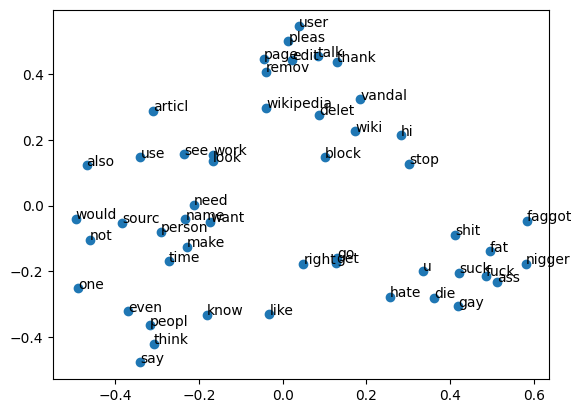

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the 100 most common words
common_words = w2v_model.wv.get_normed_vectors()[:50]

# Fit a PCA transformer to the vector data
pca = PCA(n_components=2)
result = pca.fit_transform(common_words)

# Create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])

# Annotate the points on the graph with the words themselves
words = list(w2v_model.wv.index_to_key)[:50]
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()

In [ ]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

## Binary

In [ ]:
y_train_binary = y_train[:, 0]
y_test_binary = y_test[:, 0]

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train_binary)

y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


cm = confusion_matrix(y_test_binary, y_pred)
print(cm)

print('\nAccuracy:', accuracy_score(y_test_binary, y_pred))
print('Precision:', precision_score(y_test_binary, y_pred, pos_label=1))
print('Recall:', recall_score(y_test_binary, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test_binary, y_pred, pos_label=1))

[[2790  331]
 [ 528 2469]]

Accuracy: 0.8595946387708402
Precision: 0.8817857142857143
Recall: 0.8238238238238238
F1 score: 0.8518199068483697


### Naive Bayes

In [ ]:
# Train a naive bayes classification model
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train_binary)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test_binary, y_pred)
print(cm)

print('\nAccuracy:', accuracy_score(y_test_binary, y_pred))
print('Precision:', precision_score(y_test_binary, y_pred, pos_label=1))
print('Recall:', recall_score(y_test_binary, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test_binary, y_pred, pos_label=1))

[[2781  340]
 [1043 1954]]

Accuracy: 0.7739457338999673
Precision: 0.8517872711421098
Recall: 0.6519853186519853
F1 score: 0.7386127386127387


## Multilabel

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix

# Create a OneVsRestClassifier object with LogisticRegression
model = OneVsRestClassifier(LogisticRegression(max_iter = 2000,  solver='liblinear'))

# Fit the model to the scaled data.
model.fit(X_train, y_train)

# Predict labels for test data
y_pred = model.predict(X_test)

# Calculate multilabel confusion matrix
mcm = multilabel_confusion_matrix(y_test, y_pred)
print("Multilabel Confusion Matrix:")
print(mcm)

print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall:', recall_score(y_test, y_pred, average='micro'))
print('F1 score:', f1_score(y_test, y_pred, average='micro'))

Multilabel Confusion Matrix:
[[[2789  332]
  [ 528 2469]]

 [[5758   54]
  [ 244   62]]

 [[4377  195]
  [ 542 1004]]

 [[6029    4]
  [  73   12]]

 [[4444  256]
  [ 677  741]]

 [[5844   22]
  [ 228   24]]]

Accuracy: 0.6305982347172279
Precision: 0.8332367149758454
Recall: 0.6529376135675349
F1 score: 0.7321504372187793


### Naive Bayes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix

classifier = MultiOutputClassifier(MultinomialNB())
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

mcm = multilabel_confusion_matrix(y_test, y_pred)
print("Multilabel Confusion Matrix:")
print(mcm)

print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))
# print precision
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
# print recall
print('Recall:', recall_score(y_test, y_pred, average='weighted'))

Multilabel Confusion Matrix:
[[[2799  322]
  [ 828 2169]]

 [[5812    0]
  [ 306    0]]

 [[4564    8]
  [1434  112]]

 [[6033    0]
  [  85    0]]

 [[4683   17]
  [1348   70]]

 [[5866    0]
  [ 252    0]]]

Accuracy: 0.562111801242236
F1 score: 0.4101691175664351
Precision: 0.7864089345536103
Recall: 0.3559963658388855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fine Tuning Bert (binary)


In [ ]:
import pandas as pd
import nltk

file_path = '/content/drive/MyDrive/data/train.csv'

# Load and preprocess the dataset
dataset = pd.read_csv(file_path)

# find the amount of 0 and 1 in label in position 2
max_dataset_length = 100000
not_toxic_count= dataset.iloc[:, 2].value_counts()[0]
toxic_count= dataset.iloc[:, 2].value_counts()[1]
min_count = min(not_toxic_count, toxic_count, int(max_dataset_length / 2))

# get first min count of not toxic and toxic
currect_df = dataset[dataset['toxic'] == 0].head(min_count)
toxic_df = dataset[dataset['toxic'] == 1].head(min_count)

# concat the dataframes
dataset = pd.concat([currect_df, toxic_df])
dataset_length= len(dataset)
print("database_lenght is",dataset_length)

# reset dataset index
dataset = dataset.reset_index(drop=True)

database_lenght is 30588


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Trained Model

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

model = TFAutoModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## Load Trained Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

## Change Data According to The model

In [ ]:
correct_columns = ['comment_text', 'toxic']
dataset = dataset.loc[: , correct_columns]
dataset.columns =  ['comment_text', 'label']

## Split the dataset into training, validation and test

In [ ]:
from sklearn.model_selection import train_test_split


train_texts, temp_texts, train_labels, temp_labels = train_test_split(dataset['comment_text'], dataset['label'],
                                                                    random_state = 2018,
                                                                    test_size = 0.3,
                                                                    stratify = dataset['label'])


val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels,
                                                                random_state = 2018,
                                                                test_size = 0.5,
                                                                stratify = temp_labels)

# print(train_texts.tolist())

In [ ]:
!pip install datasets
from datasets import Dataset, DatasetDict

# Convert lists to datasets
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})  # Replace with your test data
validation_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})  # Replace with your validation data

# Combine datasets into a DatasetDict
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset, 'validation': validation_dataset})


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 21411
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4589
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4588
    })
})

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)

data_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/21411 [00:00<?, ? examples/s]

Map:   0%|          | 0/4589 [00:00<?, ? examples/s]

Map:   0%|          | 0/4588 [00:00<?, ? examples/s]

In [ ]:
data_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21411
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4589
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4588
    })
})

In [ ]:
data_encoded.set_format('tf', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

In [ ]:
BATCH_SIZE = 16

def order(inp):
    '''
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.
    '''
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]

# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(data_encoded['train'][:])
# set batch_size and shuffle
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
# map the `order` function
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices(data_encoded['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(data_encoded['validation'][:])
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# print a batch from train_dataset
inp, out = next(iter(train_dataset))
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(16, 256), dtype=int64, numpy=
array([[  101,  8246,  5432, ...,     0,     0,     0],
       [  101,  2054,  6433, ...,     0,     0,     0],
       [  101,  4676,  1998, ...,     0,     0,     0],
       ...,
       [  101,  8840,  2140, ...,     0,     0,     0],
       [  101,  1047,  2059, ...,     0,     0,     0],
       [  101,  3817, 17557, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(16, 256), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'token_type_ids': <tf.Tensor: shape=(16, 256), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>} 

 tf.Tensor([1 1 0 1 1 0 1 1 1 1 1 0 

##Train The Model

In [ ]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [ ]:
classifier = BERTForClassification(model, num_classes=2)

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
history = classifier.fit(
    train_dataset,
    epochs = 2,
    validation_data = val_dataset
)

Epoch 1/2
1339/1339 [==============================] - 1387s 982ms/step - loss: 0.2048 - accuracy: 0.9170 - val_loss: 0.1665 - val_accuracy: 0.9348
Epoch 2/2
1339/1339 [==============================] - 1311s 979ms/step - loss: 0.1189 - accuracy: 0.9530 - val_loss: 0.1486 - val_accuracy: 0.9435


In [ ]:
classifier.evaluate(test_dataset)

287/287 [==============================] - 85s 296ms/step - loss: 0.1506 - accuracy: 0.9451


[0.15060967206954956, 0.9450860619544983]

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = classifier.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_labels

cm = confusion_matrix(y_true, y_pred)
print(cm)
print('\nAccuracy:', accuracy_score(y_test_binary, y_pred))
print('Precision:', precision_score(y_test_binary, y_pred, pos_label=1))
print('Recall:', recall_score(y_test_binary, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test_binary, y_pred, pos_label=1))

287/287 [==============================] - 87s 293ms/step
[[2147  148]
 [ 104 2190]]


NameError: ignored

In [ ]:
# plot loss, accuracy, trainin, validation and , test
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')

plt.legend()
plt.show()

In [ ]:
classifier.save("bert_model1")